# Peak-Valley detection in Sentinel-2 NDVI

Welcome to this Jupyter Notebook where we will be working with time series data! Our goal is to download a time series data for a meadow and use the [peak-valley](https://open-eo.github.io/FuseTS/api.html#fusets.peakvalley.peakvalley) detection algorithm originally from FuseTS to extract insights from the data. Time series analysis is a powerful tool that allows us to understand patterns and trends in data over time, and we will be leveraging this tool to analyze the data for the meadow. With the help of the FuseTS peak-valley detection algorithm, we will be able to identify the highest and lowest points in the data, allowing us to gain a better understanding of the underlying patterns and trends.

This notebook copies the FuseTS original to avoid dependency issues in the workshop!

Algorithm type: single pixel timeseries analysis

The actual peak-valley algorithm can be found here:

https://github.com/pangeo-data/pangeo-openeo-BiDS-2023/blob/main/tutorial/part3/peakvalley.py#L88

This is the 'UDF' entrypoint:
https://github.com/pangeo-data/pangeo-openeo-BiDS-2023/blob/main/tutorial/part3/peakvalley.py#L73

**Prerequisites**

- In this notebook we are using openEO to fetch the time series data for the meadow. You can register for a free trial account on the [openEO Platform](https://openeo.cloud/#plans) website.



Lets start with importing the different libraries that we need within this notebook.


In [1]:
#the autoreload extension makes it easier to work with code in a separate python file (peakvalley.py)
%load_ext autoreload
%autoreload 2

import os

import matplotlib.pyplot as plt
import numpy as np
import openeo
import rasterio
import xarray
from rasterio.features import geometry_mask


import importlib
import peakvalley
importlib.reload(peakvalley)

np.random.seed(42)

/usr/lib/python3.11/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


### Downloading the S2 time series

In order to execute the peak valley algorithm, we need to have time series data. Retrieving time series data can be done through various methods, and one such method is using openEO. [OpenEO](https://openeo.org/) is an API that provides access to a variety of Earth Observation (EO) data and processing services in a standardized and easy-to-use way. By leveraging the power of openEO, we can easily retrieve the time series data for the meadow and use it to analyze the patterns and trends.

More information on the usage of openEO's Python client can be found on [GitHub](https://github.com/Open-EO/openeo-python-client).

The first step is to connect to an openEO compatible backend.


In [2]:
connection = openeo.connect("openeo.cloud").authenticate_oidc()

Authenticated using refresh token.


Next we define the area of interest, in this case an extent, for which we would like to fetch time series data.


In [3]:
# set download extent
minx, miny, maxx, maxy = (
    15.179421073198585,
    45.80924633589998,
    15.185336903822831,
    45.81302555710934,
)
spat_ext = dict(west=minx, east=maxx, north=maxy, south=miny, crs=4326)
temp_ext = ["2022-01-01", "2022-12-31"]

We will create an openEO process to calculate the NDVI time series for our area of interest. We'll begin by using the SENTINEL2_L2A_SENTINELHUB collection, and apply a cloud masking algorithm to remove any interfering clouds before calculating the NDVI values.


In [4]:
# define openEO pipeline
s2 = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=spat_ext,
    temporal_extent=temp_ext,
    bands=["B04", "B08", "SCL"],
    max_cloud_cover=80
)
s2 = s2.process("mask_scl_dilation", data=s2, scl_band_name="SCL")
ndvi_cube = s2.ndvi(red="B04", nir="B08")

/home/driesj/python/openeo-python-client/openeo/rest/connection.py:1171: UserWarning: SENTINEL2_L2A property filtering with properties that are undefined in the collection metadata (summaries): eo:cloud_cover.
  return DataCube.load_collection(


Now that we have calculated the NDVI time series for our area of interest, we can request openEO to download the result to our local storage. This will allow us to access the file and use it for further analysis in this notebook. However, if we have already downloaded the file, we can use the existing time series to continue our analysis without the need for a new download.


In [5]:
%%time
if not os.path.exists("../data/s2_meadow.nc"):
    #job = ndvi_cube.execute_batch("../data/s2_meadow.nc", title=f"FuseTS - Peak Valley - Time Series")
    ndvi_cube.download("../data/s2_meadow.nc")

CPU times: user 514 µs, sys: 100 µs, total: 614 µs
Wall time: 906 µs


In [6]:
ds = xarray.load_dataset("../data/s2_meadow.nc")
ds

<xarray.Dataset>
Dimensions:  (t: 64, x: 48, y: 44)
Coordinates:
  * t        (t) datetime64[ns] 2022-01-02 2022-01-25 ... 2022-12-23 2022-12-28
  * x        (x) float64 5.139e+05 5.139e+05 5.14e+05 ... 5.144e+05 5.144e+05
  * y        (y) float64 5.073e+06 5.073e+06 5.073e+06 ... 5.073e+06 5.073e+06
Data variables:
    crs      |S1 b''
    var      (t, y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

In [7]:
ndvi=ds['var']

In [9]:
#download if you already have a job result
#connection.job("vito-j-2311057a8fdb4d7d89d944c693fb2d40").download_result("peakvalley.nc")

PosixPath('peakvalley.nc')

In [ ]:
#or create and run a new job
peakvalley.peakvalley(ndvi_cube, drop_thr=0.15, rec_r=1.0, slope_thr=-0.007).execute_batch("peakvalley.nc")

0:00:00 Job 'vito-j-2311057a8fdb4d7d89d944c693fb2d40': send 'start'
0:00:18 Job 'vito-j-2311057a8fdb4d7d89d944c693fb2d40': queued (progress N/A)
0:00:23 Job 'vito-j-2311057a8fdb4d7d89d944c693fb2d40': queued (progress N/A)
0:00:30 Job 'vito-j-2311057a8fdb4d7d89d944c693fb2d40': queued (progress N/A)
0:00:38 Job 'vito-j-2311057a8fdb4d7d89d944c693fb2d40': queued (progress N/A)
0:00:49 Job 'vito-j-2311057a8fdb4d7d89d944c693fb2d40': queued (progress N/A)
0:01:01 Job 'vito-j-2311057a8fdb4d7d89d944c693fb2d40': queued (progress N/A)
0:01:18 Job 'vito-j-2311057a8fdb4d7d89d944c693fb2d40': queued (progress N/A)


Now that we have calculated the NDVI time series, we can utilize it to execute the peak valley algorithm that is part of the FuseTS algorithm. The peak valley algorithm is a powerful tool that allows us to detect significant changes in the vegetation patterns over time.


In [11]:
# run peak-valley detection
pv_result = peakvalley.peakvalley(ndvi, drop_thr=0.13, rec_r=1.0, slope_thr=-0.007)
pv_result.isel(x=20,y=20)

<xarray.DataArray 'peak_valley_mask' (t: 64)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan,  1.,  0.,  0.,  0.,
       -1., nan, nan, nan, nan, nan,  1.,  0.,  0., -1., nan, nan,  1.,
       -1., nan, nan, nan, nan,  1.,  0., -1., nan, nan, nan, nan, nan,
       nan,  1.,  0., -1., nan, nan, nan, nan, nan, nan, nan, nan,  1.,
        0., -1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
      dtype=float32)
Coordinates:
  * t        (t) datetime64[ns] 2022-01-02 2022-01-25 ... 2022-12-23 2022-12-28
    x        float64 5.141e+05
    y        float64 5.073e+06

In [12]:
pv_result_openeo = xarray.load_dataset("./peakvalley.nc")
pv_result_openeo['var'].isel(x=20,y=20)

<xarray.DataArray 'var' (t: 64)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan,  1.,  0.,  0.,  0.,
       -1., nan, nan, nan, nan, nan,  1.,  0.,  0., -1., nan, nan,  1.,
       -1., nan, nan, nan, nan,  1.,  0., -1., nan, nan, nan, nan, nan,
       nan,  1.,  0., -1., nan, nan, nan, nan, nan, nan, nan, nan,  1.,
        0., -1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
Coordinates:
  * t        (t) datetime64[ns] 2022-01-02 2022-01-25 ... 2022-12-23 2022-12-28
    x        float64 5.141e+05
    y        float64 5.073e+06
Attributes:
    long_name:     var
    units:         
    grid_mapping:  crs

### Plot Image Chips Across Time


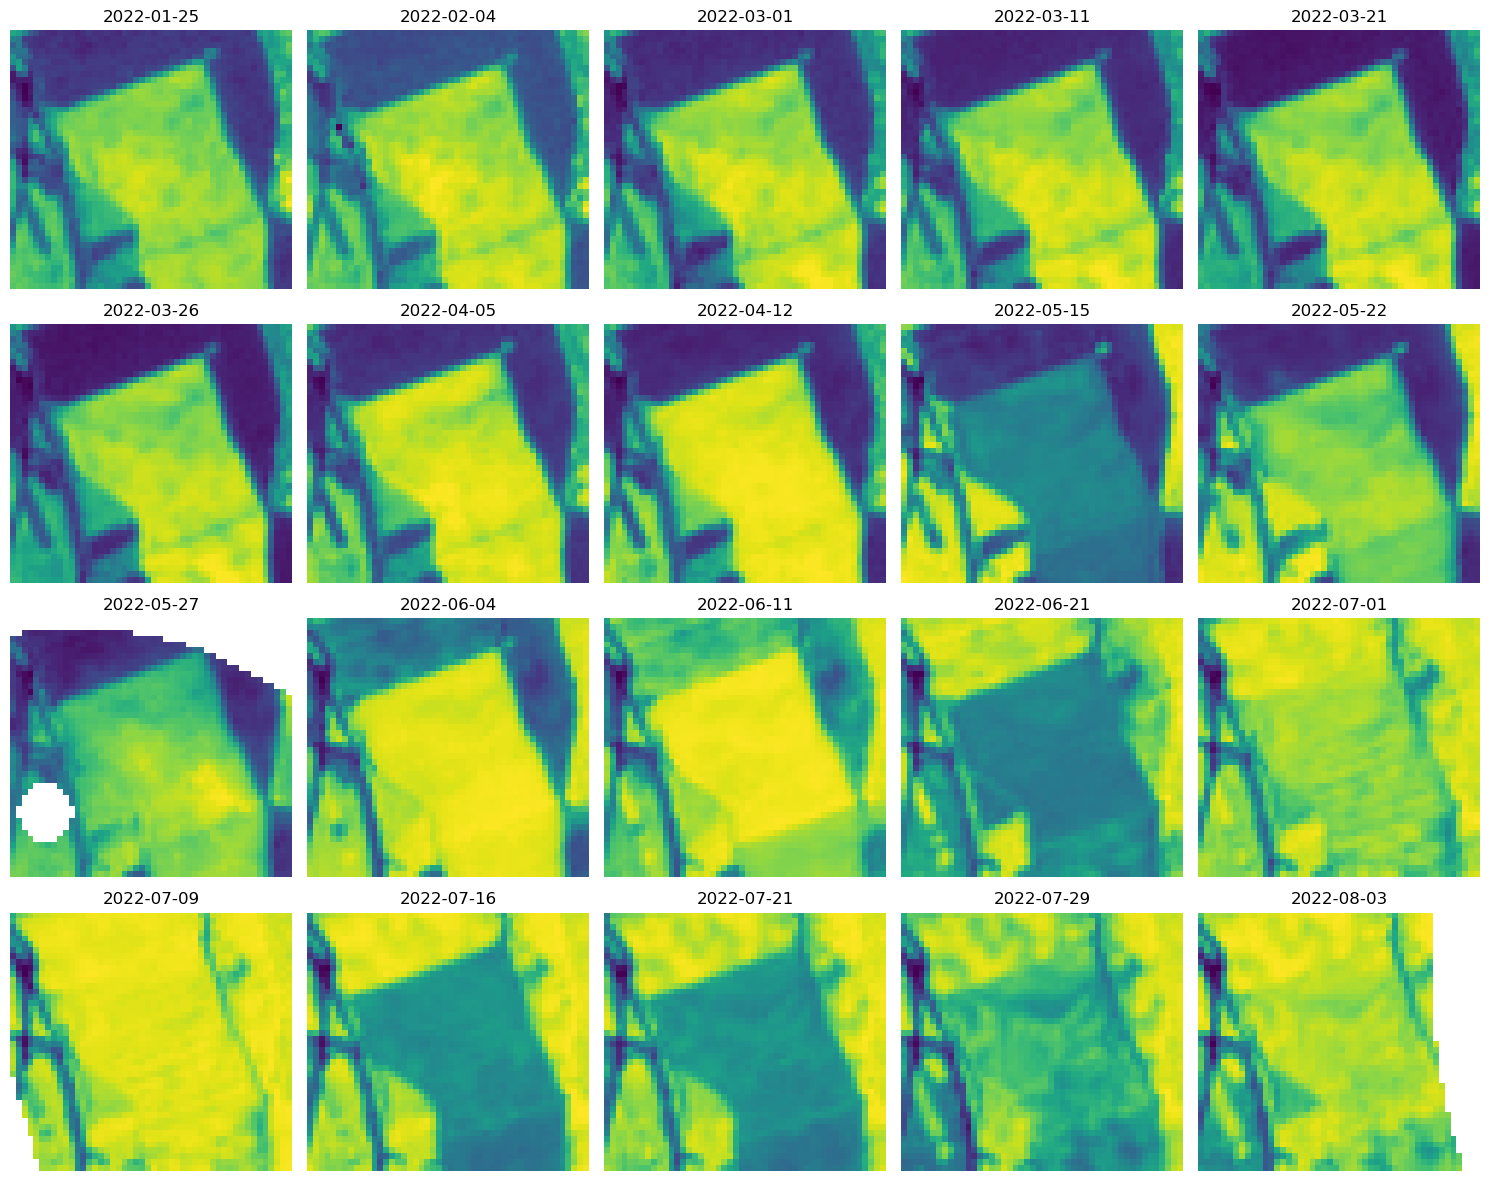

In [13]:
# take observations with more 80% of valid data or more
mask = np.count_nonzero(~np.isnan(ndvi), axis=(1, 2)) / np.prod(ndvi[0].shape) > 0.8
ndvi_filtered = ndvi.isel(t=mask)

ncols = 5
nrows = 4
plt.style.use(["default"])
fig, axs = plt.subplots(figsize=(3 * ncols, 3 * nrows), ncols=ncols, nrows=nrows)
fig.patch.set_alpha(1)

for ax, img in zip(axs.flatten(), ndvi_filtered.isel(t=slice(0, -1, 2))):
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(img.t.dt.date.to_numpy())

plt.tight_layout()

### Plot Time Series for Specific Polygon Area


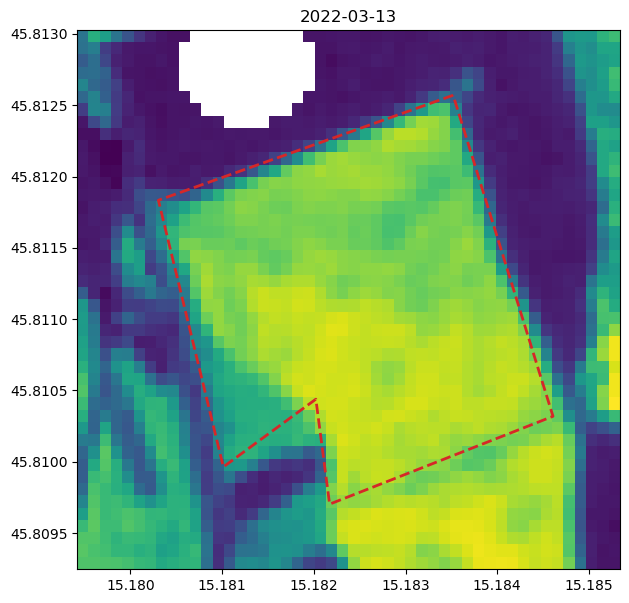

In [14]:
# define geometry of area-of-interest (AOI)
geometry = {
    "type": "Polygon",
    "coordinates": [
        [
            [15.183519, 45.81257],
            [15.180305, 45.811834],
            [15.181013, 45.809964],
            [15.182022, 45.810439],
            [15.182172, 45.809703],
            [15.184608, 45.810319],
            [15.183519, 45.81257],
        ]
    ],
}

fig, ax = plt.subplots(figsize=(7, 7))

# plot AOI
ax.imshow(ndvi_filtered.isel(t=7), extent=[minx, maxx, miny, maxy])
ax.plot(*np.array(geometry["coordinates"][0]).T, "C3", lw=2, ls="dashed")
ax.set_title(ndvi_filtered.isel(t=7).t.dt.date.to_numpy())
ax.set_aspect("auto")

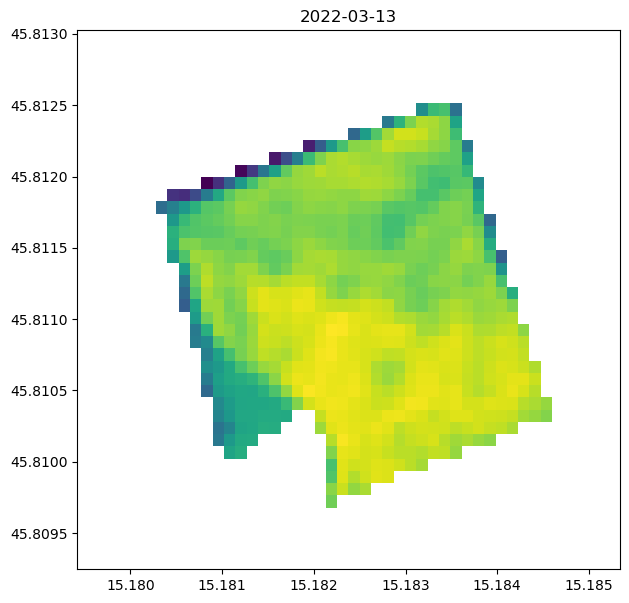

In [15]:
# define AOI mask
geom_mask = geometry_mask(
    [geometry],
    out_shape=ndvi_filtered[0].shape,
    transform=rasterio.transform.from_bounds(
        *(minx, miny, maxx, maxy),
        width=ndvi_filtered.sizes["x"],
        height=ndvi_filtered.sizes["y"],
    ),
    invert=True,
)
geom_mask = xarray.DataArray(geom_mask, dims=("y", "x"))

# filter to AOI
ndvi_masked = ndvi_filtered.where(geom_mask == True)

fig, ax = plt.subplots(figsize=(7, 7))

# plot result
ax.imshow(ndvi_masked.isel(t=7), extent=[minx, maxx, miny, maxy])
ax.set_title(ndvi_masked.isel(t=7).t.dt.date.to_numpy())
ax.set_aspect("auto")

We plot the result two times: once the local computation and then the openEO result.
Plots should be the same!

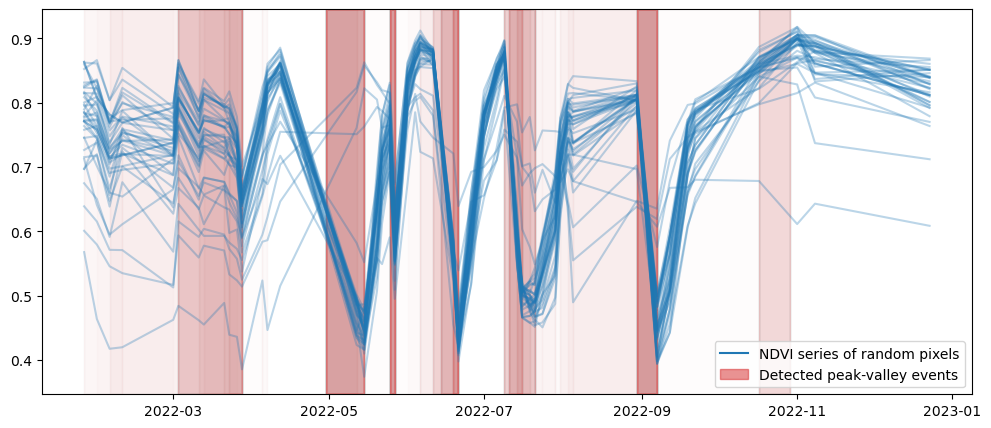

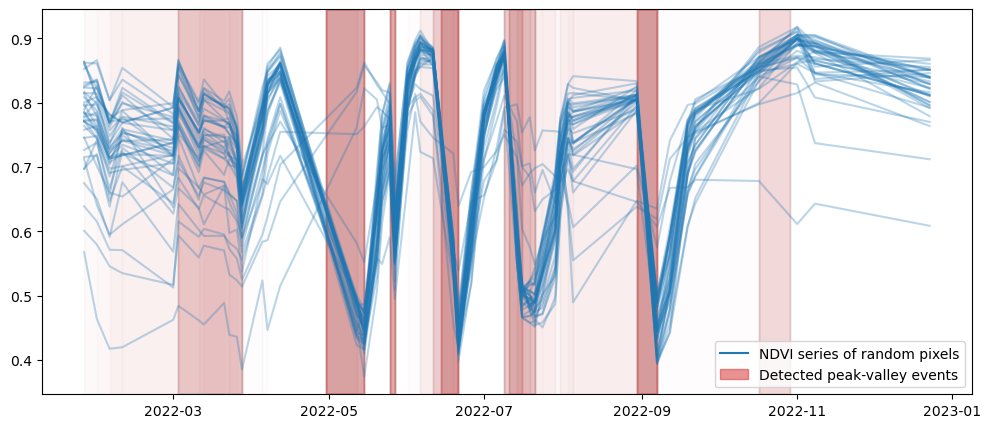

In [16]:
# sample random pixels
valid_x, valid_y = np.where(geom_mask)
rand_x = np.random.choice(valid_x, 50)
rand_y = np.random.choice(valid_y, 50)

def plot_peak_valley(pv):



    fig, ax = plt.subplots(figsize=(12, 5))

    for idx, idy in zip(rand_x, rand_y):
        # filter potential nan values
        ts = ndvi_masked.isel(x=idx, y=idy)
        ts = ts[~np.isnan(ts)]

        # extract peak-valley info
        data = pv.isel(x=idx, y=idy)
        pairs = np.transpose([np.where(data == 1)[0], np.where(data == -1)[0]])

        # plot time series
        ax.plot(ts.t, ts, "C0", alpha=0.3)

        if len(pairs) > 0:
            for pair in pairs:
                # plot peak-valley span
                ax.axvspan(*data[pair].t.to_numpy(), color="C3", alpha=0.01)

    # add legends
    ax.plot([], [], "C0", label="NDVI series of random pixels")
    ax.axvspan(None, None, color="C3", alpha=0.5, label="Detected peak-valley events")
    ax.legend()
plot_peak_valley(pv_result)
plot_peak_valley(pv_result_openeo['var'])